<a href="https://colab.research.google.com/github/Anudeepsadda/Medicinal_Plants_Leaves_Classification_Using_DeepLearning_and_Image_Processing/blob/main/Leaf_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Leaf Model

In [ ]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from PIL import UnidentifiedImageError

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import UnidentifiedImageError

# Define paths
main_dataset_dir = '/content/drive/MyDrive/Medicinal Leaf Dataset//content/drive/MyDrive/Medicinal Leaf Dataset//content/drive/MyDrive/Medicinal Leaf Dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
augmented_train_dir = 'dataset_5/augmented_train'

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import UnidentifiedImageError

# Define paths - Corrected the path to the dataset
main_dataset_dir = '/content/drive/MyDrive/Medicinal Leaf Dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'  # Corrected path
augmented_train_dir = 'dataset_5/augmented_train'

# Create directories if they don't exist
os.makedirs(augmented_train_dir, exist_ok=True)

# List all classes, ignoring hidden files
classes = [d for d in os.listdir(main_dataset_dir) if os.path.isdir(os.path.join(main_dataset_dir, d)) and not d.startswith('.')]

# ... (Rest of the code remains the same)

In [ ]:
# Create directories if they don't exist
os.makedirs(augmented_train_dir, exist_ok=True)

# List all classes, ignoring hidden files
classes = [d for d in os.listdir(main_dataset_dir) if os.path.isdir(os.path.join(main_dataset_dir, d)) and not d.startswith('.')]

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

desired_num_images = 1000

for cls in classes:
    class_dir = os.path.join(main_dataset_dir, cls)
    augmented_train_class_dir = os.path.join(augmented_train_dir, cls)

    os.makedirs(augmented_train_class_dir, exist_ok=True)

    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    if not images:
        print(f"No images found for class {cls}. Skipping...")
        continue

    # Split data: 100% for augmentation
    train_images = images

    def generate_augmented_images(image_list, target_dir, required_images):
        """Generates augmented images to reach the required total count."""
        for img_name in image_list:
            img_path = os.path.join(class_dir, img_name)
            try:
                img = load_img(img_path, target_size=(128, 128))   # Adjust the target size as needed
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Calculate number of augmentations needed per original image
                num_augmented_samples = max((required_images - len(image_list)) // len(image_list), 0)

                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=target_dir, save_prefix='aug', save_format='jpg'):
                    i += 1
                    if i >= num_augmented_samples:
                        break
            except UnidentifiedImageError:
                print(f"Cannot identify image file {img_path}. Skipping...")

    # Generate augmented images for training set
    generate_augmented_images(train_images, augmented_train_class_dir, desired_num_images)

    # Copy remaining original images to the training set if needed to reach desired count
    current_train_images = len(os.listdir(augmented_train_class_dir))
    if current_train_images < desired_num_images:
        for img_name in train_images:
            img_path = os.path.join(class_dir, img_name)
            try:
                shutil.copy(img_path, augmented_train_class_dir)
            except Exception as e:
                print(f"Error copying image {img_path}: {e}")

print("Augmented training data generation complete.")

Augmented training data generation complete.


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
augmented_train_dir = 'dataset_5/augmented_train'
train_dir = 'dataset_5/train'
validation_dir = 'dataset_5/validation'

In [ ]:
# Create directories for training and validation if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# List all classes
classes = [d for d in os.listdir(augmented_train_dir) if os.path.isdir(os.path.join(augmented_train_dir, d)) and not d.startswith('.')]

for cls in classes:
    class_augmented_dir = os.path.join(augmented_train_dir, cls)
    class_train_dir = os.path.join(train_dir, cls)
    class_validation_dir = os.path.join(validation_dir, cls)

    # Create directories for each class in train and validation directories
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_validation_dir, exist_ok=True)

    # List all images in the class directory
    images = [f for f in os.listdir(class_augmented_dir) if os.path.isfile(os.path.join(class_augmented_dir, f))]

    if len(images) == 0:
        print(f"No images found in {class_augmented_dir}. Skipping...")
        continue

    print(f"Processing {len(images)} images for class {cls}.")

    # Split the images into training and validation sets
    try:
        train_images, validation_images = train_test_split(images, test_size=0.2, random_state=42)
    except ValueError as e:
        print(f"Error splitting images for class {cls}: {e}")
        continue

    # Copy training images to the train directory
    for img_name in train_images:
        src = os.path.join(class_augmented_dir, img_name)
        dst = os.path.join(class_train_dir, img_name)
        shutil.copy(src, dst)

    # Copy validation images to the validation directory
    for img_name in validation_images:
        src = os.path.join(class_augmented_dir, img_name)
        dst = os.path.join(class_validation_dir, img_name)
        shutil.copy(src, dst)

print("Training and validation data split complete.")

Processing 963 images for class Nyctanthes Arbor-tristis (Parijata).
Processing 934 images for class Mentha (Mint).
Processing 945 images for class Ficus Auriculata (Roxburgh fig).
Processing 942 images for class Amaranthus Viridis (Arive-Dantu).
Processing 939 images for class Psidium Guajava (Guava).
Processing 950 images for class Ocimum Tenuiflorum (Tulsi).
Processing 923 images for class Plectranthus Amboinicus (Mexican Mint).
Processing 915 images for class Syzygium Jambos (Rose Apple).
Processing 905 images for class Punica Granatum (Pomegranate).
Processing 936 images for class Santalum Album (Sandalwood).
Processing 917 images for class Artocarpus Heterophyllus (Jackfruit).
Processing 906 images for class Muntingia Calabura (Jamaica Cherry-Gasagase).
Processing 954 images for class Mangifera Indica (Mango).
Processing 942 images for class Syzygium Cumini (Jamun).
Processing 918 images for class Azadirachta Indica (Neem).
Processing 905 images for class Tabernaemontana Divarica

In [ ]:
classes = [d for d in os.listdir(augmented_train_dir) if os.path.isdir(os.path.join(augmented_train_dir, d)) and not d.startswith('.')]

In [ ]:
image_size = (128, 128)
batch_size = 32

In [ ]:
 datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir ,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 22343 images belonging to 30 classes.
Found 5598 images belonging to 30 classes.


In [ ]:

model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')
])


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


699/699 ━━━━━━━━━━━━━━━━━━━━ 52s 64ms/step - accuracy: 0.3409 - loss: 2.2428 - val_accuracy: 0.8303 - val_loss: 0.5316
Epoch 2/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.7996 - loss: 0.6410 - val_accuracy: 0.9059 - val_loss: 0.3036
Epoch 3/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.8890 - loss: 0.3465 - val_accuracy: 0.9371 - val_loss: 0.1985
Epoch 4/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.9206 - loss: 0.2444 - val_accuracy: 0.9477 - val_loss: 0.1499
Epoch 5/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.9401 - loss: 0.1822 - val_accuracy: 0.9557 - val_loss: 0.1356
Epoch 6/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.9509 - loss: 0.1447 - val_accuracy: 0.9568 - val_loss: 0.1339
Epoch 7/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.9584 - loss: 0.1242 - val_accuracy: 0.9405 - val_loss: 0.1809
Epoch 8/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.9602 - loss: 0.1175 - val_accurac

In [ ]:
model.save('leaf_classifier_2.h5')

In [ ]:
val_loss,val_accuarcy=model.evaluate(val_generator)

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9691 - loss: 0.1098


In [ ]:
train_loss,train_accuarcy=model.evaluate(train_generator)

699/699 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9988 - loss: 0.0074


In [ ]:
print(f"Validation accuarcy:{val_accuarcy *100:.2f}%")

Validation accuarcy:96.96%


In [ ]:
print(f"Validation loss:{val_loss *100:.2f}%")

Validation loss:11.13%


In [ ]:
print(f"traning accuarcy:{train_accuarcy *100:.2f}%")

traning accuarcy:99.84%


In [ ]:
print(f"traning loss:{train_loss *100:.2f}%")

traning loss:0.83%


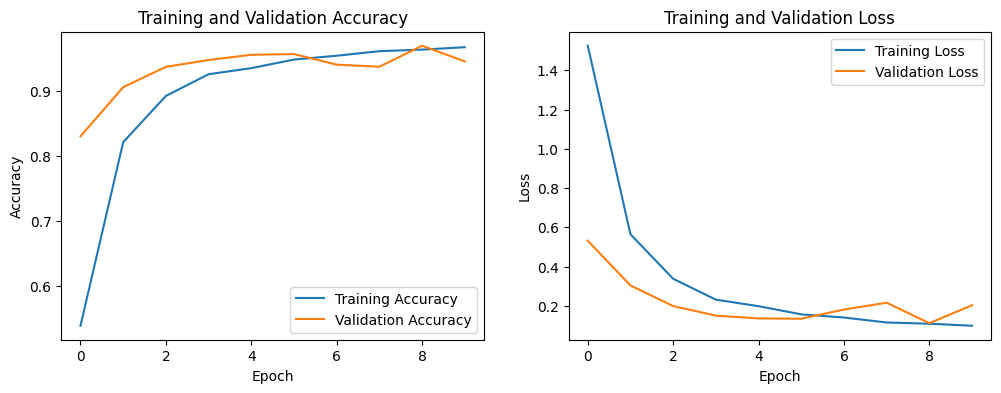

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [ ]:
# Define paths
validation_dir = 'dataset_5/validation'

In [ ]:
# Define your validation data generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5598 images belonging to 30 classes.


In [ ]:
# Predict on the validation data
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
predictions = model.predict(validation_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step


In [ ]:
# Convert true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

In [ ]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.95      0.98      0.97       192
            Amaranthus Viridis (Arive-Dantu)       0.99      0.93      0.96       189
        Artocarpus Heterophyllus (Jackfruit)       0.99      0.99      0.99       184
                   Azadirachta Indica (Neem)       0.98      0.98      0.98       184
                       Basella Alba (Basale)       0.97      0.98      0.97       180
            Brassica Juncea (Indian Mustard)       0.99      0.97      0.98       190
                  Carissa Carandas (Karanda)       0.95      0.98      0.97       186
                        Citrus Limon (Lemon)       0.98      0.82      0.90       187
             Ficus Auriculata (Roxburgh fig)       0.95      0.94      0.94       189
               Ficus Religiosa (Peepal Tree)       1.00      0.99      0.99       181
                      Hibiscus Rosa-sinensis       0.

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [ ]:
model = load_model('leaf_classifier_2.h5')

In [ ]:
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image
        return img_array
    except UnidentifiedImageError:
        print("Error: The image at the specified path could not be identified.")
        return None

In [ ]:
def predict_leaf_name(image_path, model, class_indices):
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        return
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

In [ ]:
class_indices = train_generator.class_indices

In [ ]:
image_path = '/content/dataset_5/validation/Artocarpus Heterophyllus (Jackfruit)/AH-S-024.jpg'
predicted_leaf_name = predict_leaf_name(image_path, model, class_indices)
print(f"Predicted Leaf Name: {predicted_leaf_name}")

image_path = '/content/dataset_5/validation/Artocarpus Heterophyllus (Jackfruit)/AH-S-024.jpg'

# Check if the file exists
if not os.path.exists(image_path):
    print(f"Error: Image file not found at '{image_path}'")
    # You can either exit the program or handle the error appropriately
    # For example, you can try a different image path or skip this image
    # exit()  # Uncomment this line to exit the program if the file is not found

predicted_leaf_name = predict_leaf_name(image_path, model, class_indices)
print(f"Predicted Leaf Name: {predicted_leaf_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Predicted Leaf Name: Artocarpus Heterophyllus (Jackfruit)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Leaf Name: Artocarpus Heterophyllus (Jackfruit)


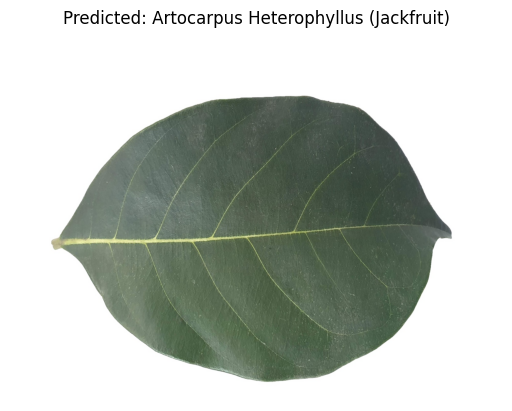

In [ ]:
def plot_image_with_prediction(image_path, predicted_label):
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

plot_image_with_prediction(image_path, predicted_leaf_name)

Leaf Predictions

In [ ]:
import os
import numpy as np
import pandas as pd
import requests
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import UnidentifiedImageError

In [ ]:
model = load_model('leaf_classifier_2.h5')

In [ ]:
 df = pd.read_csv('leaf.csv')

In [ ]:
print(df.columns)

Index(['plant_name ', 'scientific_name', 'features', 'description'], dtype='object')


In [ ]:
plant_names = df['plant_name '].values
scientific_names = df['scientific_name'].values
features = df['features'].values

In [ ]:
class_indices = {name: idx for idx, name in enumerate(plant_names)}
plant_uses = {name: feature for name, feature in zip(plant_names, features)}

In [ ]:
image_dir = 'Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
os.makedirs(image_dir, exist_ok=True)

In [ ]:
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image
        return img_array
    except UnidentifiedImageError:
        print("Error: The image at the specified path could not be identified.")
        return None

In [ ]:
def predict_leaf_name(image_path, model, class_indices):
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        return None, None
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}  # Invert the class indices
    predicted_class_label = class_labels[predicted_class_index]
    predicted_uses = plant_uses.get(predicted_class_label, "No use information available.")
    return predicted_class_label, predicted_uses

In [ ]:
def plot_image_with_prediction_and_uses(image_path, predicted_label, uses):
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}\nUses: {uses}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


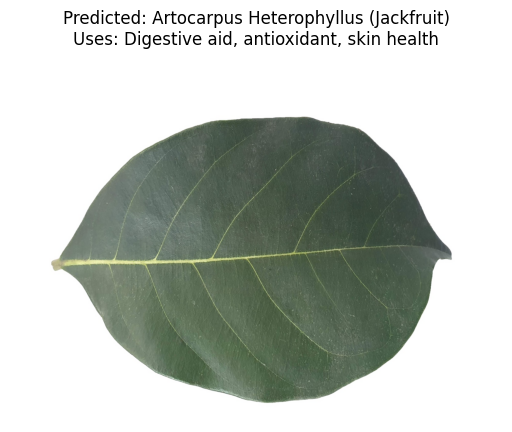

In [ ]:
image_path = '/content/dataset_5/validation/Artocarpus Heterophyllus (Jackfruit)/AH-S-024.jpg'  # Specify the local path to the image
predicted_label, predicted_uses = predict_leaf_name(image_path, model, class_indices)
if predicted_label and predicted_uses:
    plot_image_with_prediction_and_uses(image_path, predicted_label, predicted_uses)

ROC Curve

175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


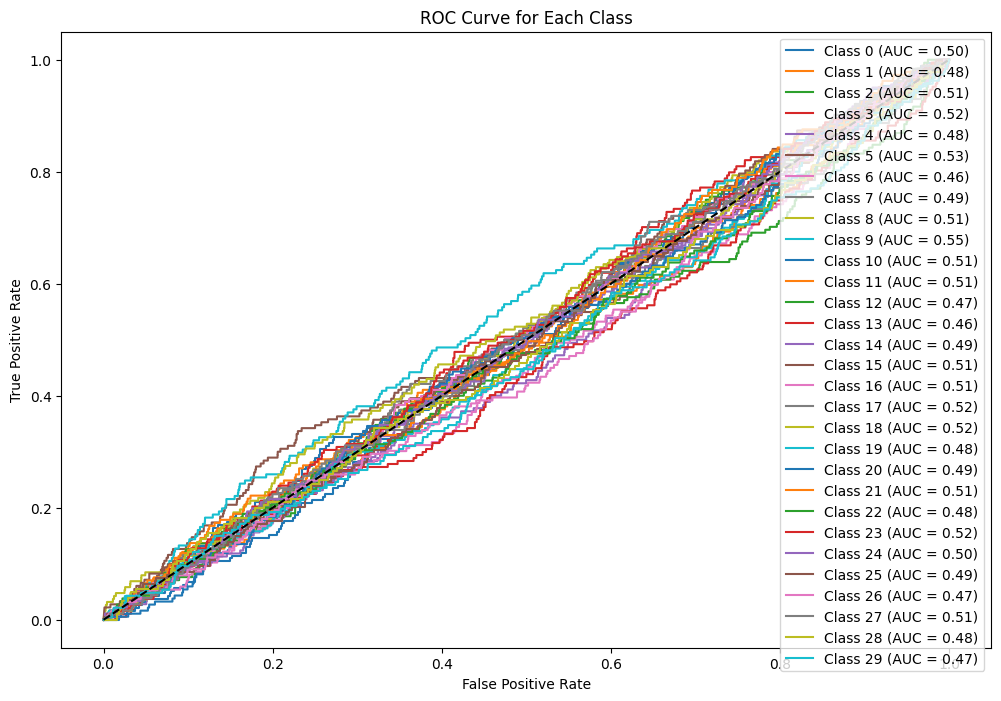

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities
val_labels = val_generator.classes
pred_probs = model.predict(val_generator)
n_classes = pred_probs.shape[1]

# Binarize the true labels for multi-class ROC curve
val_labels_binarized = label_binarize(val_labels, classes=range(n_classes))

# Plotting ROC for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(val_labels_binarized[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.show()

Data Visualization

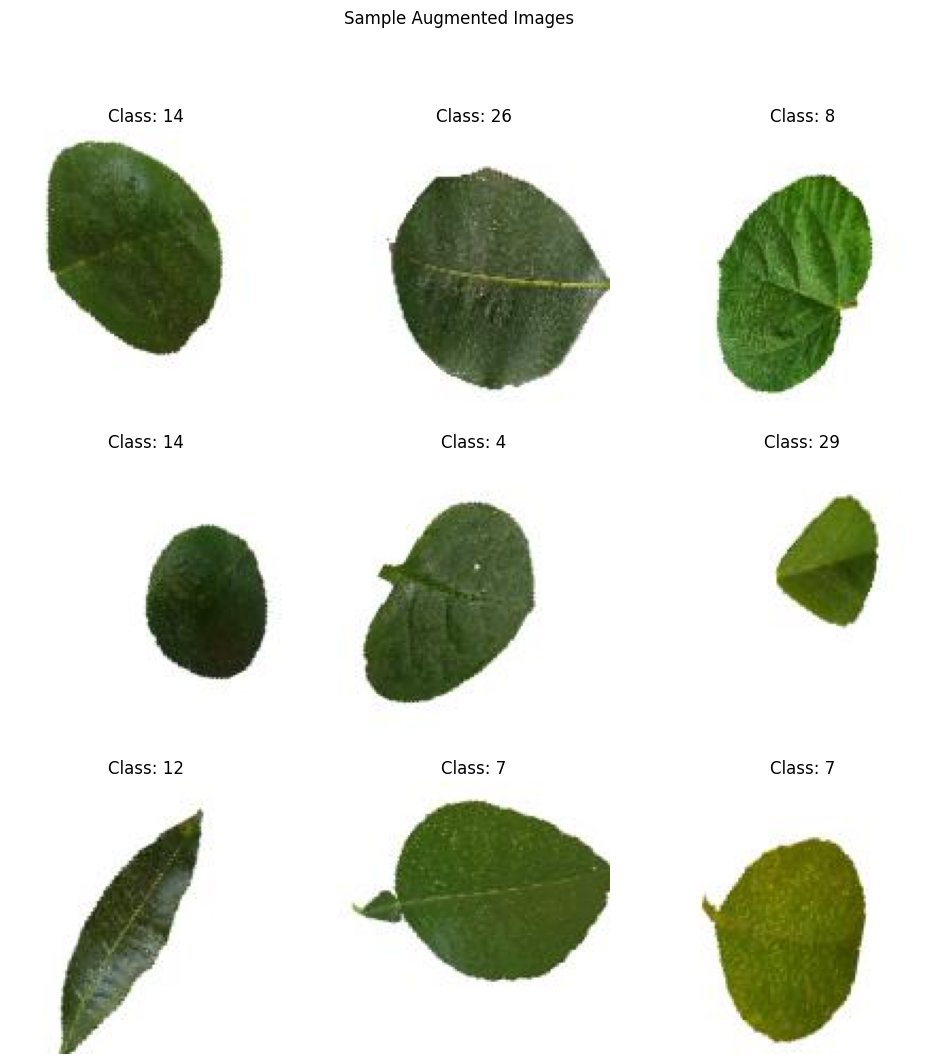

In [ ]:
import numpy as np

# Get a batch of augmented images
batch = next(train_generator)
images, labels = batch[0], batch[1]

# Plot a few images
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f'Class: {np.argmax(labels[i])}')
plt.suptitle("Sample Augmented Images")
plt.show()

699/699 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step


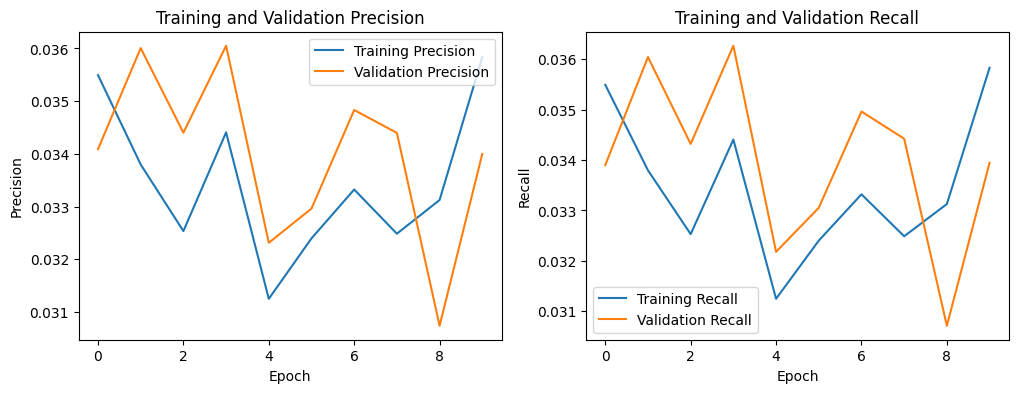

In [ ]:
from sklearn.metrics import precision_score, recall_score

train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

for epoch in range(len(history.history['accuracy'])):
    # Predict on train and validation sets for each epoch
    train_preds = model.predict(train_generator)
    val_preds = model.predict(val_generator)

    train_labels = train_generator.classes
    val_labels = val_generator.classes

    # Get predictions as class indices
    train_preds = np.argmax(train_preds, axis=1)
    val_preds = np.argmax(val_preds, axis=1)

    # Calculate precision and recall for each epoch
    train_precision = precision_score(train_labels, train_preds, average='macro')
    train_recall = recall_score(train_labels, train_preds, average='macro')
    val_precision = precision_score(val_labels, val_preds, average='macro')
    val_recall = recall_score(val_labels, val_preds, average='macro')

    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

# Plot precision and recall over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')

plt.show()

Class Distribution

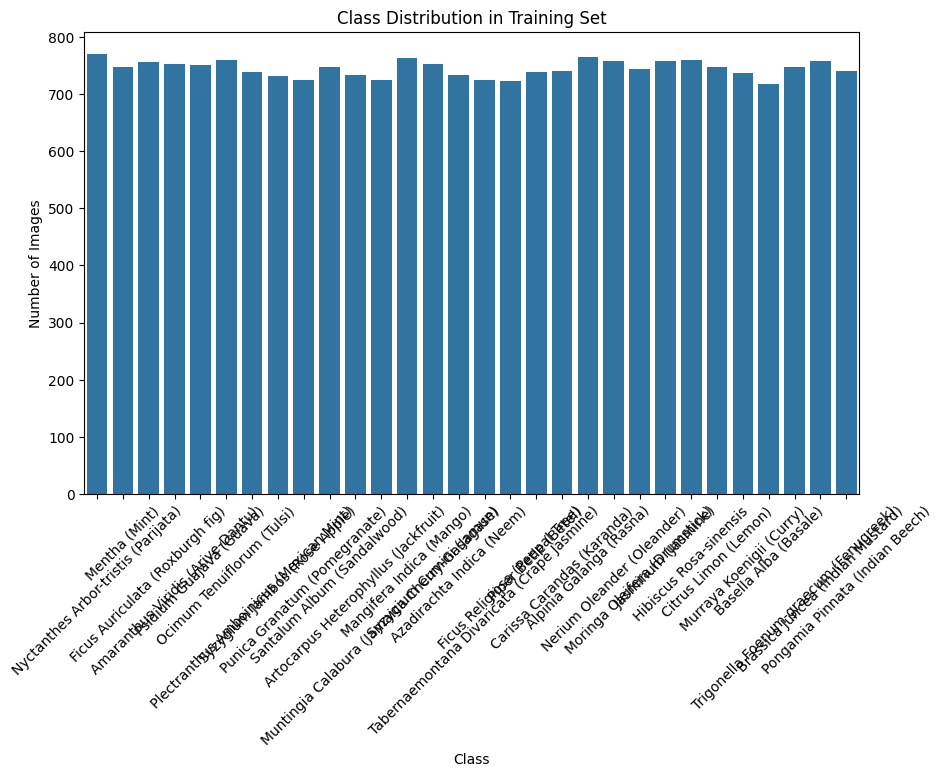

In [ ]:
import seaborn as sns

# Count images per class in the training set
train_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()))
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

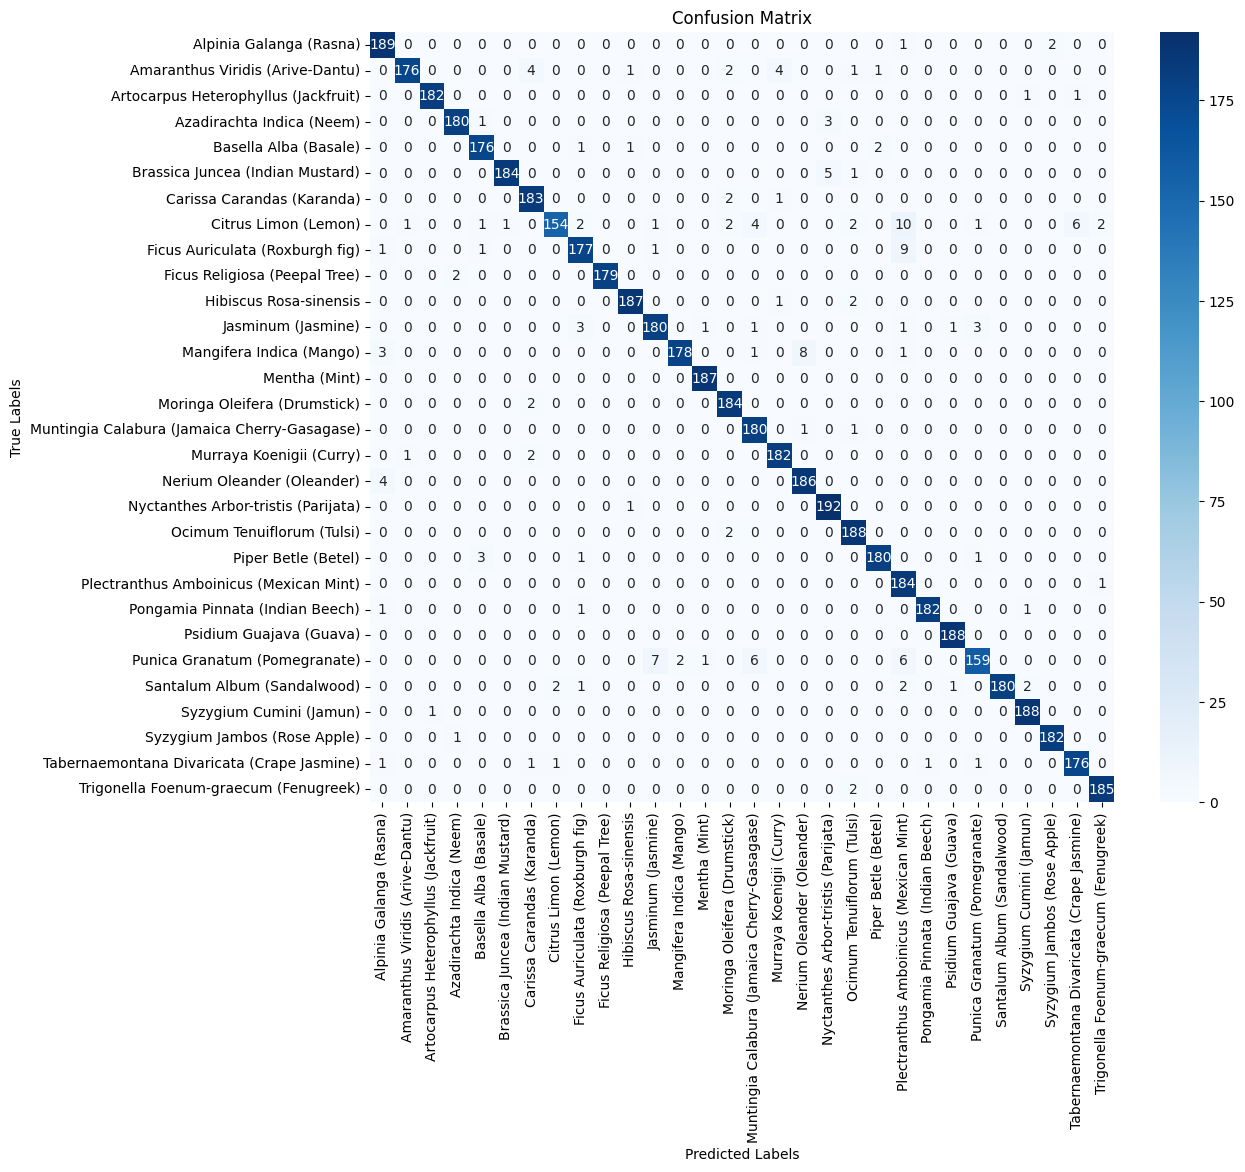

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()